## EfficientNetB0
### Database: [Plant Diseases Training Dataset](https://www.kaggle.com/datasets/nirmalsankalana/plant-diseases-training-dataset/data)

In [8]:
#Import nessesary packages, libraries and global variables

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from  PIL import Image
import numpy as np
from tensorflow.keras import Input, Model
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import split_dataset
import tensorflow as tf
from tensorflow import keras


RSEED = 42
dataset_path = '../data/train/'

In [11]:
#from ..loard_split_preprocess_function.py import load_preprocess_split_train_val
#train_data, val_data = load_preprocess_split_train_val(dataset_path)



In [9]:
#getting impatient

def load_preprocess_split_train_val(data_path):
    ''' 
    Function needs filefath as parameter, it will create a validation dataset of 20% of the total df, 
    Needs an RSEED as global variable,
    Image will be cropped to 1:1 and altered to 224 x 224
    '''
    image = tf.keras.utils.image_dataset_from_directory(
        data_path, 
        validation_split = 0.2,
        subset = "both", 
        seed = RSEED,
        image_size = (224, 224),
        crop_to_aspect_ratio = True,
        label_mode = 'categorical'
    )
    return image 

In [10]:
train_ds, val_ds = load_preprocess_split_train_val(dataset_path)

Found 76697 files belonging to 39 classes.
Using 61358 files for training.
Using 15339 files for validation.


2024-02-12 09:33:04.394107: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-02-12 09:33:04.394134: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-02-12 09:33:04.394143: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-02-12 09:33:04.394556: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-12 09:33:04.394902: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
#check an example 
val_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 39), dtype=tf.float32, name=None))>

------------------------------------------------------------------------------------------------------------------------------------------
#### Developing a model
------------------------------------------------------------------------------------------------------------------------------------------

In [12]:
from tensorflow.keras.applications import DenseNet121
K.clear_session()

NameError: name 'K' is not defined

In [24]:
#define model

model = keras.applications.EfficientNetB0(
    include_top=False
)

In [25]:
#get overview of the model architecture

model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, None, None, 3)        0         ['input_4[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, None, None, 3)        7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, None, None, 3)        0         ['normalization_2

In [26]:
# Define the input layer with the shape of input images
inputs = Input(shape=(224, 224, 3))

# Pass the input through the base layers of an existing model
base = model(inputs)

# Apply global average pooling to reduce spatial dimensions
flatten = GlobalAveragePooling2D()(base)

# Add a fully connected layer for classification with softmax activation
outputs = Dense(39, activation='softmax')(flatten)

# Construct the final model with input and output layers
model_enB0 = Model(inputs, outputs)

In [27]:
# Compile the model with Adam optimizer, learning rate of 0.001. 
# sparse_categorical_crossentropydesigned for categorical labels that are not one-hot encoded

model_enB0.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
from keras import layers
IMG_SIZE = 224
BATCH_SIZE = 32

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)) # Define the input layer with the shape of input images
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet") # Load the EfficientNetB0 model pretrained on ImageNet without the top classification layer
                                                                                        # Use the input layer defined above

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output) # Apply global average pooling to the output of the base layers
    x = layers.BatchNormalization()(x) # Apply batch normalization to normalize the activations of the previous layer


    top_dropout_rate = 0.2 # Define the dropout rate
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x) # Apply dropout regularization to the previous layer
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x) # Add a dense layer for classification with softmax activation

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet") # Construct the final model with the specified input and output layers
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-2) # Define the optimizer with a learning rate of 0.01 using the Adam optimizer
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    
    return model

In [29]:
model = build_model(num_classes=39)

epochs = 12  # @param {type: "slider", min:8, max:80}
#hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)


In [30]:


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

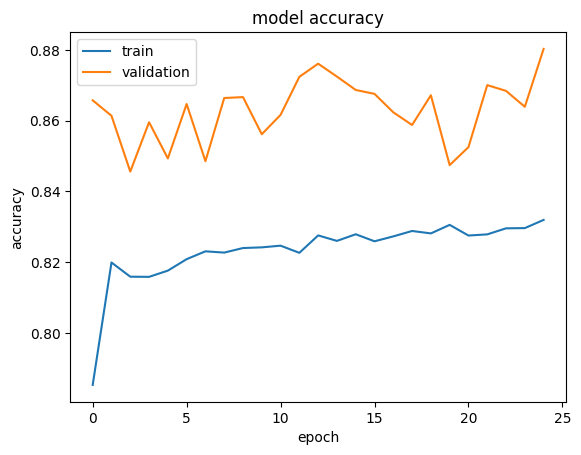

In [14]:
plot_hist(hist)

In [31]:
#next we want to unfreeze a couple of layers and retrain with own data

import tensorflow as tf

def unfreeze_model_and_clone(model):
    # Clone the original model
    unfrozen_model = tf.keras.models.clone_model(model)
    unfrozen_model.set_weights(model.get_weights())  # Copy weights

    # Unfreeze the top 10 layers while leaving BatchNorm layers frozen
    for layer in unfrozen_model.layers[-10:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5)
    unfrozen_model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    
    return unfrozen_model


In [ ]:
# Create a new model with unfrozen layers
unfrozen_model = unfreeze_model_and_clone(model)

epochs = 4
hist = unfrozen_model.fit(train_ds, epochs=epochs, validation_data=val_ds)


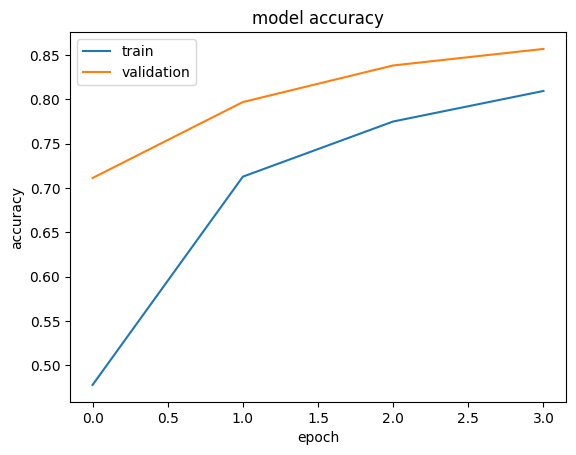

In [19]:
plot_hist(hist)

Epoch 1/8
1918/1918 [==============================] - 530s 275ms/step - loss: 2.1398 - accuracy: 0.4816 - val_loss: 1.0859 - val_accuracy: 0.7108
Epoch 2/8
1918/1918 [==============================] - 1694s 883ms/step - loss: 1.0449 - accuracy: 0.7128 - val_loss: 0.7107 - val_accuracy: 0.7955
Epoch 3/8
1918/1918 [==============================] - 514s 268ms/step - loss: 0.7646 - accuracy: 0.7786 - val_loss: 0.5569 - val_accuracy: 0.8330
Epoch 4/8
1918/1918 [==============================] - 2495s 1s/step - loss: 0.6295 - accuracy: 0.8136 - val_loss: 0.4742 - val_accuracy: 0.8543
Epoch 5/8
1918/1918 [==============================] - 559s 291ms/step - loss: 0.5442 - accuracy: 0.8357 - val_loss: 0.4236 - val_accuracy: 0.8693
Epoch 6/8
1918/1918 [==============================] - 521s 271ms/step - loss: 0.4897 - accuracy: 0.8495 - val_loss: 0.3864 - val_accuracy: 0.8798
Epoch 7/8
1918/1918 [==============================] - 521s 272ms/step - loss: 0.4475 - accuracy: 0.8593 - val_loss: 0.

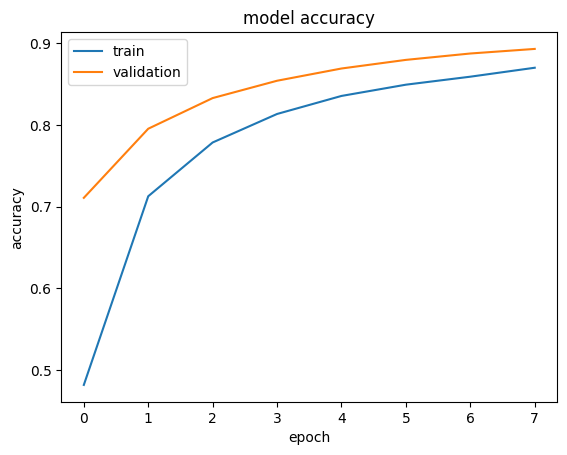

In [33]:
# Create a new model with unfrozen layers
unfrozen_model2 = unfreeze_model_and_clone(model)

epochs = 8
hist = unfrozen_model2.fit(train_ds, epochs=epochs, validation_data=val_ds)

plot_hist(hist)


Epoch 1/15
1918/1918 [==============================] - 6942s 4s/step - loss: 0.3852 - accuracy: 0.8784 - val_loss: 0.3236 - val_accuracy: 0.8975
Epoch 2/15
1918/1918 [==============================] - 509s 265ms/step - loss: 0.3618 - accuracy: 0.8848 - val_loss: 0.3084 - val_accuracy: 0.9033
Epoch 3/15
1918/1918 [==============================] - 1568s 818ms/step - loss: 0.3405 - accuracy: 0.8918 - val_loss: 0.2975 - val_accuracy: 0.9048
Epoch 4/15
1918/1918 [==============================] - 1161s 605ms/step - loss: 0.3270 - accuracy: 0.8953 - val_loss: 0.2880 - val_accuracy: 0.9077
Epoch 5/15
1918/1918 [==============================] - 512s 267ms/step - loss: 0.3126 - accuracy: 0.8991 - val_loss: 0.2807 - val_accuracy: 0.9098
Epoch 6/15
1918/1918 [==============================] - 7434s 4s/step - loss: 0.2978 - accuracy: 0.9036 - val_loss: 0.2728 - val_accuracy: 0.9117
Epoch 7/15
1918/1918 [==============================] - 507s 264ms/step - loss: 0.2884 - accuracy: 0.9076 - val_lo

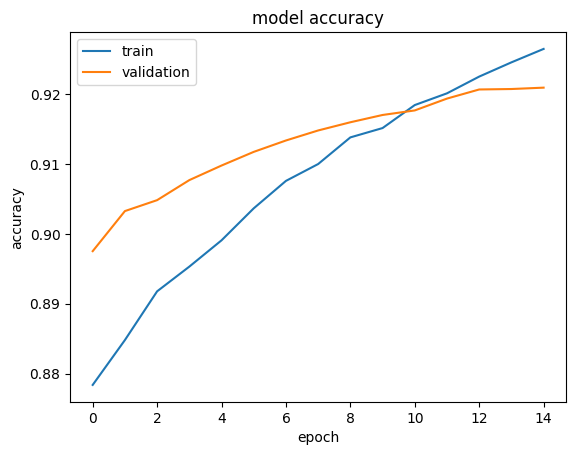

In [34]:
# Create a new model with unfrozen layers
unfrozen_model3 = unfreeze_model_and_clone(model)

epochs = 15
hist3 = unfrozen_model2.fit(train_ds, epochs=epochs, validation_data=val_ds)

plot_hist(hist3)

In [35]:
# Create a new model with unfrozen layers
unfrozen_model4 = unfreeze_model_and_clone(model_enB0)

epochs = 4
hist4 = unfrozen_model4.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/4
1918/1918 [==============================] - 1842s 951ms/step - loss: 1.7583 - accuracy: 0.5924 - val_loss: 0.7071 - val_accuracy: 0.8025
Epoch 2/4
1918/1918 [==============================] - ETA: 0s - loss: 0.6301 - accuracy: 0.8210

KeyboardInterrupt: 

In [ ]:
plot_hist(hist4)

------------------------------------------------------------------------------------------------------------------------------------------
#### Testing of the model with unseen data
------------------------------------------------------------------------------------------------------------------------------------------

In [36]:


def load_test(data_path):
    ''' 
    Function needs filepath as parameter, it will create a validation dataset of 20% of the total df, 
    Needs an RSEED as global variable,
    Image will be cropped to 1:1 and altered to 224 x 224
    '''
    image = tf.keras.utils.image_dataset_from_directory(
        data_path,
        image_size = (224, 224),
        crop_to_aspect_ratio = True,
        label_mode = 'categorical'
    )
    return image 

In [37]:
dataset_test_path = '../data/test/'

test_ds = load_test(dataset_test_path)

Found 19174 files belonging to 39 classes.


In [38]:
#check an example 
test_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 39), dtype=tf.float32, name=None))>

In [39]:
# Make predictions on the test dataset
predictions = model.predict(test_ds)

600/600 [==============================] - 128s 210ms/step


In [40]:
# Make predictions on the test dataset
predictions = unfrozen_model3.predict(test_ds)

600/600 [==============================] - 128s 210ms/step


In [49]:
# Get the true labels from the file paths
true_labels = []
for filepath in test_ds.file_paths:
    label = os.path.basename(os.path.dirname(filepath))
    true_labels.append(label)

# Create a list of unique classes
classes = sorted(set(true_labels))

# Create a mapping from class names to indices
class_to_index = {cls: i for i, cls in enumerate(classes)}

# Convert true labels to indices
true_labels_indices = [class_to_index[label] for label in true_labels]

In [45]:
true_labels = np.array(true_labels)

In [46]:
# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

In [6]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(true_labels_indices, predicted_classes , normalize='pred')
# Display the confusion matrix
print("Confusion Matrix:")
print(cm)


NameError: name 'true_labels_indices' is not defined

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns


# Display the confusion matrix using seaborn heatmap with green color palette
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Greens", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

NameError: name 'cm' is not defined

<Figure size 1000x800 with 0 Axes>